# Análisis predictivo del consumo eléctrico en la ciudad de Barcelona

El principal objetivo de este ejercicio es mostrar cómo realizar, de una forma didáctica, un análisis predictivo de series temporales partiendo de datos abiertos sobre el consumo de electricidad en la ciudad de Barcelona. Para ello realizaremos un análisis exploratorio de los datos, definiremos y validaremos el modelo predictivo para, por último, generar las predicciones junto a sus gráficas y visualizaciones correspondientes.

## 1. Preparación de los datos

Lo primero que debemos hacer es importar y cargar las librerías que utilizaremos en el ejercicio.

*    [pandas](https://pandas.pydata.org/) es una librería de Python especializada en el manejo y análisis de estructuras de datos.
*    [matplotlib](https://matplotlib.org/) es una librería de Python especializada en la creación de visualizaciones
*    [seaborn](https://seaborn.pydata.org/) es una librería de Python basada en matplotlib especializada en la creación de visualizaciones.
*    [git](https://gitpython.readthedocs.io/en/stable/) es una librería de Python que permite interactuar con el sistema de control de versiones Github.
*    [xgboost](https://xgboost.readthedocs.io/en/stable/) es una librería de Python para la implementación de algoritmos de machine learning en el marco de "Gradient Boosting"


In [1]:
# Importación de las librerías a utilizar en el ejercicio
!pip install gitpython

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import git
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


Una vez instaladas e importadas las librerías que utilizaremos, cargamos los conjuntos de datos originales. Estos conjuntos de datos son publicados por el Ayuntamiento de Barcelona en el [catálogo de datos.gob.es](https://datos.gob.es/es/catalogo/l01080193-consumo-de-electricidad-mwh-por-codigo-postal-sector-economico-y-tramo-horario)

In [2]:
# Clonamos el repositorio de Github con los conjuntos de datos originales en el entorno de Google Colaboratory
git.Repo.clone_from("https://github.com/datosgobes/Laboratorio-de-Datos.git", "Datos origen")

# Creamos una función que importe, agrupe y adapte el tipo de variables de los conjuntos de datos de origen a utilizar
def primera (x):
  data = pd.read_csv("/content/Datos origen/Visualizaciones/Análisis_predictivo_consumo_BCN/Datos_origen/" + str(x) + "_consumo_BCN.csv")
  data_agrupado = data.groupby(['Sector_Economic','Data'])['Valor'].sum().reset_index()
  data_agrupado['Data'] = pd.to_datetime(data_agrupado['Data'])
  return data_agrupado

# Hacemos llamado a la función anterior para generar las tablas de datos correspondientes
data_2019 = primera(2019)
data_2020 = primera(2020)
data_2021 = primera(2021)
data_2022 = primera(2022)

# Imprimimos por pantalla las primeras filas de una de las tablas de datos para verificar su contenido
data_2022.head()

,Sector_Economic,Data,Valor
0,Indústria,2022-01-01,964700
1,Indústria,2022-01-02,1019860
2,Indústria,2022-01-03,1393808
3,Indústria,2022-01-04,1371396
4,Indústria,2022-01-05,1354421


## 2. Análisis exploratorio de los datos (EDA)

En primer lugar, unimos las tablas de datos obtenidas anteriormente correspondientes a cada uno de los años en una sola que recoja el total de la serie temporal de datos.

In [3]:
# Concatenamos de forma vertical las tablas de datos obtenidas en el punto anterior en una sola
data = pd.concat([data_2019, data_2020, data_2021, data_2022])

# Imprimimos en pantalla la principal información de la tabla de datos resultante
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5844 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Sector_Economic  5844 non-null   object        
 1   Data             5844 non-null   datetime64[ns]
 2   Valor            5844 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 182.6+ KB


Modificamos el nombre de las variables y de algunos de sus registros, agrupamos por conmuso total por día, para finalmente generar un archivo con la tabla de datos en formato .csv que podremos descargar en la sección de archivos (parte superior izquierda de la interfaz de Google Colaboratory).

Este archivo es el que utilizamos en "Looker Studio" para generar las visualizaciones interactivas embebidas en el post.

In [4]:
# Modificamos el nombre de las variables
data.rename(columns = {"Data":"fecha","Valor":"valor", "Sector_Economic":"sector_economico"}, inplace=True)

# Agrupamos la tabla de datos por consumo total por día
data = data.groupby(['fecha']).sum().reset_index()

# Guardamos la tabla de datos
data.to_csv("tabla_datos_exploratorio.csv")

Para identificar de forma numérica en que fecha ocurren los outliers utilizaremos una de las formas comunes de identificalos que es mediante el uso de los cuartiles y del rango intercuartil.

In [5]:
# Calculamos el rango intercuartil (IQR), es decir, la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de la tabla de datos
Q1 = data['valor'].quantile(0.25)
Q3 = data['valor'].quantile(0.75)
IQR = Q3 -Q1

# Definimos límites para identificar outliers
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

# Encontramos e imprimimos por pantalla los valores que se encuentren fuera del rango definido
outliers = data[(data['valor'] < umbral_inferior) | (data['valor'] > umbral_superior)]
print(outliers)

          fecha     valor
203  2019-07-23  24377531
204  2019-07-24  24621090
205  2019-07-25  24569613
307  2019-11-04  24088180
308  2019-11-05  24304325
309  2019-11-06  24172827
310  2019-11-07  24117897
311  2019-11-08  24305304
314  2019-11-11  25810919
315  2019-11-12  25671454
316  2019-11-13  25797481
317  2019-11-14  26240156
318  2019-11-15  26556701
321  2019-11-18  26644622
322  2019-11-19  27098562
323  2019-11-20  27148520
324  2019-11-21  26622080
325  2019-11-22  25899680
328  2019-11-25  25621644
329  2019-11-26  25590363
330  2019-11-27  25142797
331  2019-11-28  24939295
332  2019-11-29  24540172
366  2020-01-02  24306329
367  2020-01-03  24802710
371  2020-01-07  26089577
372  2020-01-08  26604626
373  2020-01-09  26618185
374  2020-01-10  26759652
377  2020-01-13  27620754
378  2020-01-14  27472551
379  2020-01-15  27129263
380  2020-01-16  26822982
381  2020-01-17  26078291
384  2020-01-20  28476453
385  2020-01-21  28921002
386  2020-01-22  27721315
387  2020-01

Se ha decidido modificar unicamente el registrado en la fecha "2022-12-05". Para ello se sustituira el valor por la media del registrado el día anterior y el día siguiente.

<Axes: xlabel='fecha'>

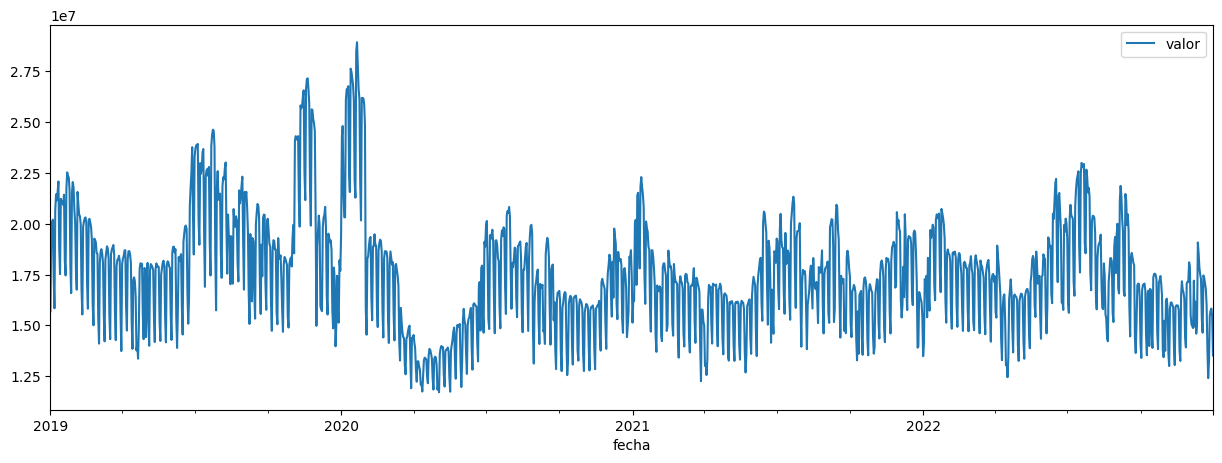

In [6]:
# Elegimos la fecha del valor a sustituir del outlier
fecha = "2022-12-05"

# Obtenemos la fila anterior y siguiente a la fecha a modificar
fila_anterior = data[data["fecha"] < fecha].iloc[-1]
fila_siguiente = data[data["fecha"] > fecha].iloc[0]

# Calculamos la media y modificamos el valor en la tabla de datos
media = (fila_anterior["valor"] + fila_siguiente["valor"]) / 2
data.loc[data["fecha"] == fecha, "valor"] = media

# Ploteamos la serie temporal para comprobar que se ha realizado el cambio anterior correctamente
data.plot(figsize=(15,5), x='fecha', y='valor', linestyle='-')

## 3. Entrenamiento del modelo


Creamos los atributos temporales correspondientes a la tabla de datos

In [7]:
# La varible fecha la convertimos al índice de la tabla de datos
data= data.set_index('fecha')

In [8]:
# Definimos una función en la que se crean los atributos
def creacion_atributos(df):
  df['dia_semana'] = df.index.dayofweek
  df['dia_año'] = df.index.dayofyear
  df['trimestre'] = df.index.quarter
  df['mes'] = df.index.month
  df['año'] = df.index.year
  return df

# Llamamos a la función creada anteriormente para generar los atributos en la tabla de datos
data_total = creacion_atributos(data)

Ploteamos gráficas de cajas con los valores según los atributos creados anteriormente para entender la distribucción e importancia de cada uno de ellos dentro de la serie temporal.

Text(0.5, 1.0, 'Diagrama de cajas por atributo día de la semana')

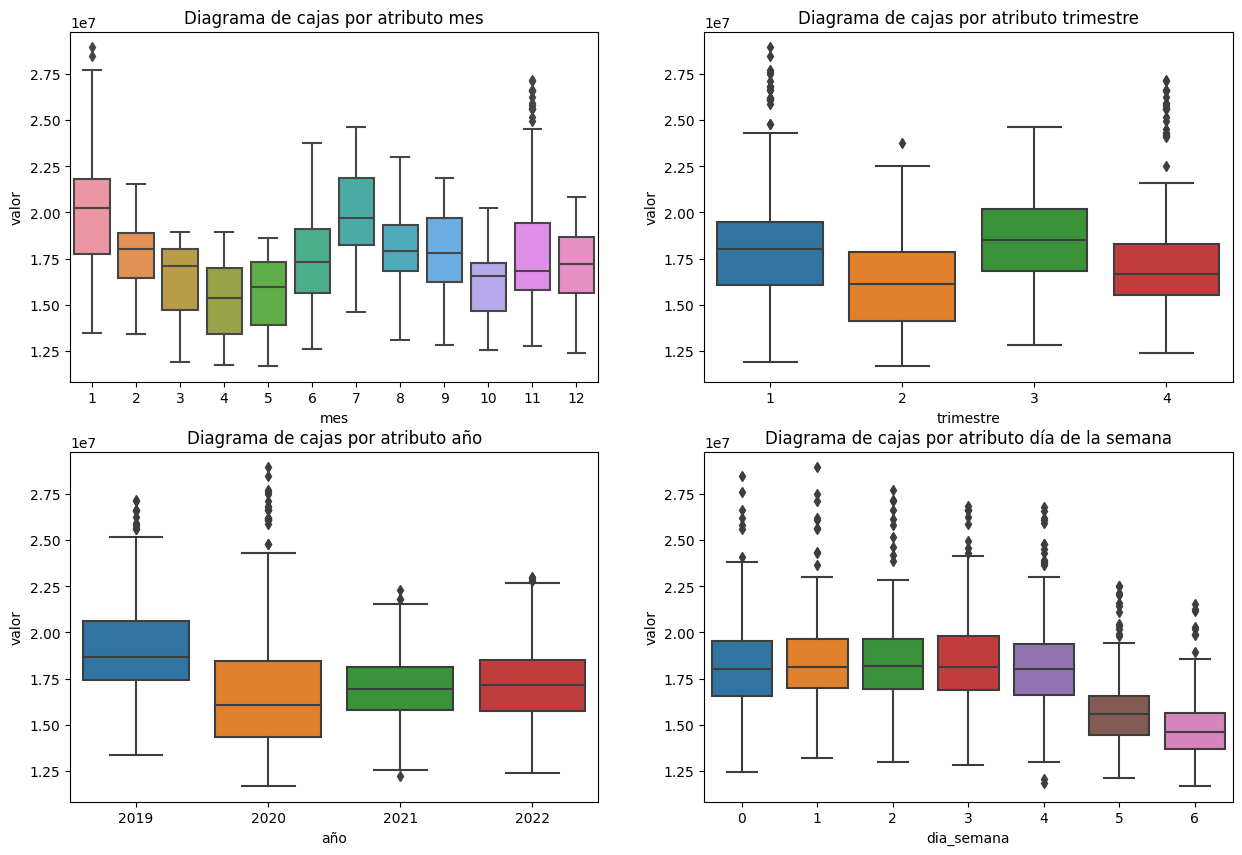

In [9]:
# Plotear los atributos para ver su importancia
fig, axes = plt.subplots(2,2, figsize=(15,10))

sns.boxplot(data=data_total, x="mes", y="valor", ax=axes[0,0]).set_title("Diagrama de cajas por atributo mes")
sns.boxplot(data=data_total, x="trimestre", y="valor", ax=axes[0,1]).set_title("Diagrama de cajas por atributo trimestre")
sns.boxplot(data=data_total, x="año", y="valor", ax=axes[1,0]).set_title("Diagrama de cajas por atributo año")
sns.boxplot(data=data_total, x="dia_semana", y="valor", ax=axes[1,1]).set_title("Diagrama de cajas por atributo día de la semana")


Dividimos los datos en set de entrenamiento y set de validación ploteandolos a continuación para apreciar la división de forma visual.

In [10]:
# Dividimos la tabla de datos en dos sets, uno para el entrenamiento (70%) y el otro para la validación (30%)
train = data.loc[data.index < pd.to_datetime('11-01-2021')]
test = data.loc[data.index > pd.to_datetime('11-01-2021')]

<Axes: xlabel='fecha'>

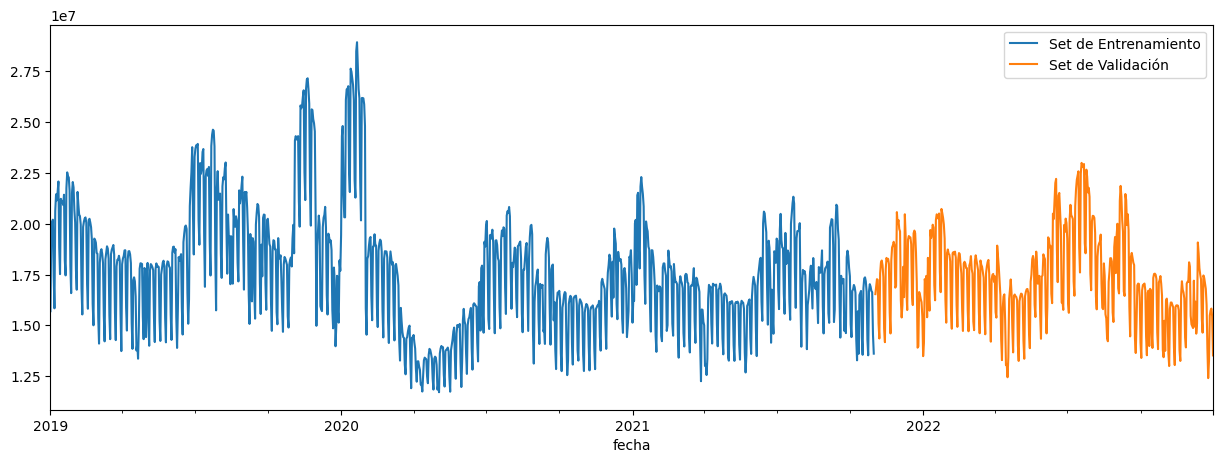

In [11]:
# Ploteamos los dos subsets creados anteriormente en la misma serie temporal
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, y='valor', label='Set de Entrenamiento')
test.plot(ax=ax, y='valor', label='Set de Validación')

Dividimos los sets de entrenamiento y de validación según sus atributos y la variable objetivo.

In [12]:
# Creamos una lista con las variables atributos y la variable objetivo
atributos = ['dia_semana', 'mes', 'año', 'dia_año', 'trimestre']
objetivo = 'valor'

In [13]:
# Dividimos los sets de entrenamiento y validación según las listas creadas anteriormente
X_train = train[atributos]
y_train = train[objetivo]

X_test = test[atributos]
y_test = test[objetivo]

Definimos y entrenamos el modelo. Para ello utilizamos los sets de entrenamiento y validación generados en puntos anteriores y realizamos un ajuste de los distintos parámetros del modelo.

In [14]:
# Definimos y entrenamos al modelo
reg = xgb.XGBRegressor(n_estimators=100,
                       early_stopping_rounds=100,
                       learning_rate= 0.3,
                       max_depth = 6,
                       min_child_wight = 1,
                       gamma = 0,
                       colsample_bytree = 1,
                       subsample = 1)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, min_child_wight=1,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

Por último en este apartado, ploteamos la importancia que ha tenido cada uno de los atributos temporales durante el entrenamiento del modelo.

<Axes: >

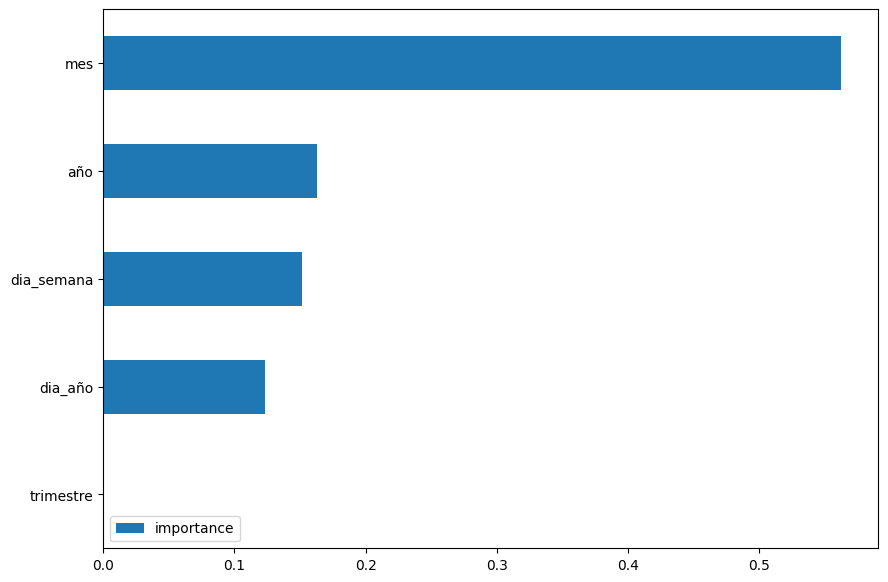

In [26]:
# Graficar la importancia de cada uno de los atributos
fi = pd.DataFrame(data = reg.feature_importances_,
              index=reg.feature_names_in_,
                  columns=['importance'])
fig, ax = plt.subplots(figsize=(10, 7))
fi.sort_values('importance').plot(kind='barh', ax=ax)


## 4. Validación del modelo

Una vez entrenado el modelo y entendido su funcionamiento, generamos una nueva columna con las predicciones del valor de demanda eléctrica y la añadimos a la tabla de datos inicial.

In [16]:
# Predicciones para el año 2022
test['prediccion']= reg.predict(X_test)

# Añadir a la tabla de datos las predicciones obtenidas
data_total = data_total.merge(test[['prediccion']], how="left", left_index=True, right_index=True)

Evaluamos el modelo visualmente ploteando las predicciones junto a los valores reales.

<Axes: xlabel='fecha'>

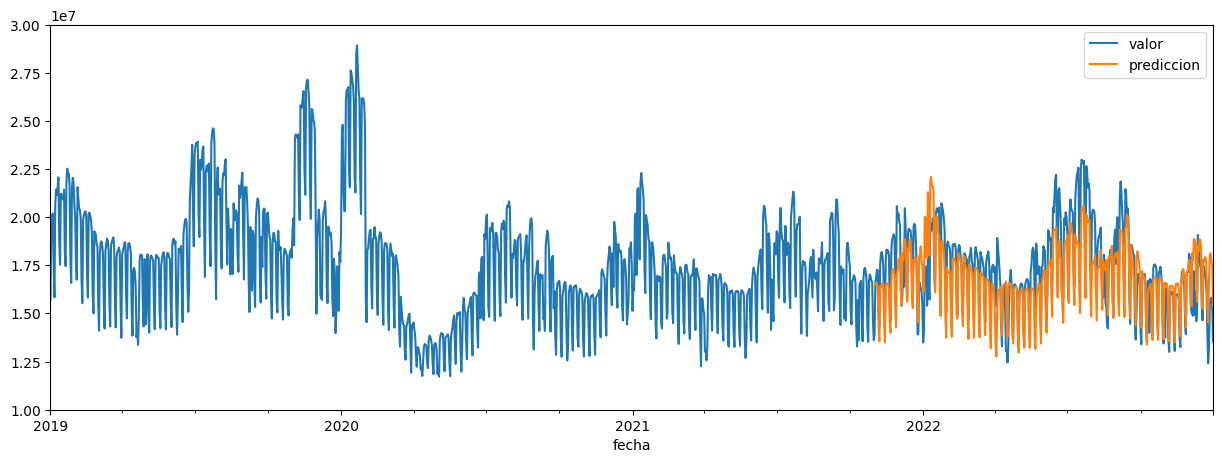

In [17]:
# Ploteamos el valor real de la demanda eléctrica junto a la predicción para tener una referencia visual de lo acertado que es el modelo
ax = data_total[['valor']].plot(figsize=(15,5))
ax.set_ylim(10000000 ,30000000)
data_total[['prediccion']].plot(ax=ax, style='-')

Usamos la métrica del error porcentual absoluto medio (MAPE - Mean Absolute Percentage Error) para evaluar el funcionamiento del modelo de forma numérica.

In [18]:
# Error porcentual absoluto medio (MAPE – Mean Absolute Percentage Error) como métrica de evaluación de las prediciones de serie temporal
test["Porcentaje"] = (abs(test["prediccion"] - test["valor"]) / test["valor"]) * 100
test["Porcentaje"].mean()

6.583638880901582

## 5. Predicción valores futuros

Una vez validado el modelo, lo entrenamos nuevamente con el total de los datos históricos que tenemos, es decir, hasta finales del 2022

In [19]:
# Dividimos la tabla de datos completa según atributos y objetivo
X_all = data_total[atributos]
y_all = data_total[objetivo]

# Re-entrenamos el modelo con los datos hasta finales del 2022
reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, min_child_wight=1,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

Generamos las predicciones de consumo eléctrico para el año 2023, añadiendolas a la tabla de datos con los valores reales.

In [20]:
# Creamos un dataset para rellenarlo con las predicciones futuras del año 2023
future = pd.date_range('2023-01-01', '2023-12-30')
df_future = pd.DataFrame(index=future)

# Creamos los atributos en el dataset
df_future = creacion_atributos(df_future)

# Juntamos la tabla de datos reales al dataset creado anteriormente
df_final = pd.concat([data_total, df_future])

In [21]:
# Generamos las predicciones para el año 2023 y las añadimos a la tabla de datos iniciales.
df_future['prediccion']= reg.predict(df_future[atributos])
df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)

<Axes: >

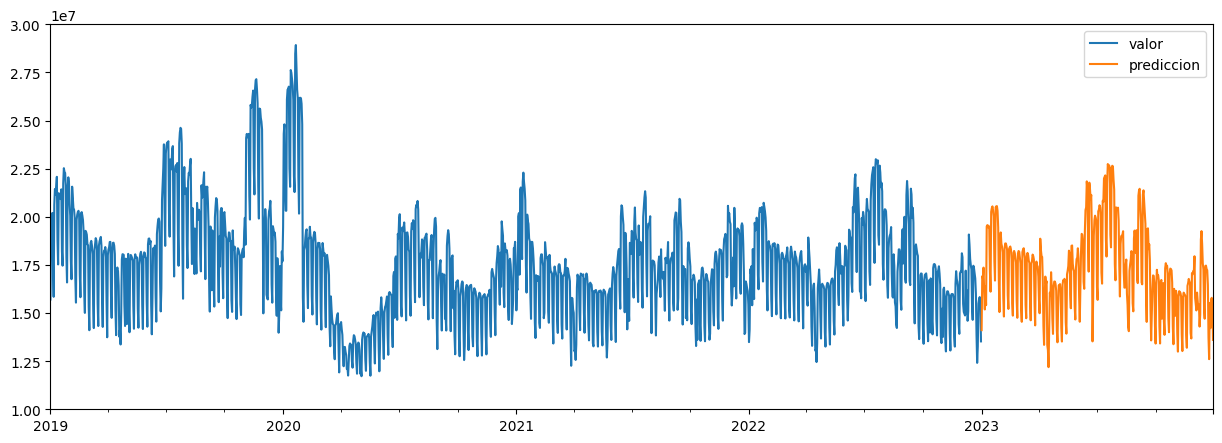

In [22]:
# Graficamos la serie temporal con los valores reales de consumo y la predicción para el 2023
ax = df_final[['valor']].plot(figsize=(15, 5))
ax.set_ylim(10000000,30000000 )
df_future[['prediccion']].plot(ax=ax)

Por último, guardamos en una nueva tabla de datos los resultados de las prediciones, de cara a poder mostrarlas en una visualización interactiva

In [23]:
# Generamos y guardamos en un archivo .csv la tabla de datos con las predicciones
df_future.to_csv("tabla_datos_predicciones.csv")